In [98]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pmdarima as pm
import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
warnings.filterwarnings('ignore')

In [99]:
df = pd.read_parquet("data/dataset_procesada.parquet", engine="pyarrow")
df

,exportaciones,importaciones,precio_petroleo,igae,pib,consumo_final,inversion_total,tasa_inflacion
fecha,,,,,,,,
2008-10-01,-0.454482,-0.299724,-4.956194,0.037897,0.038064,0.581546,0.414413,-0.060587
2009-01-01,-1.812458,-0.796024,-1.256884,-0.886494,-0.886777,-0.798865,-0.811319,-1.995298
2009-04-01,0.356706,0.603206,1.470491,1.032076,1.032046,0.188213,0.485071,4.119722
2009-07-01,0.512052,0.556132,0.794157,-0.273556,-0.273605,-0.096622,-0.070220,-1.670576
2009-10-01,0.117188,0.069532,0.725736,0.123238,0.123502,0.652331,0.510964,-0.177565
...,...,...,...,...,...,...,...,...
2023-10-01,-0.949204,-0.144119,-0.283497,1.441632,1.441919,1.999727,0.736056,-0.302286
2024-01-01,-1.801562,-1.529920,-0.049535,-1.893434,-1.893470,-1.957061,-1.796246,0.082974
2024-04-01,1.673592,0.960185,0.375641,0.491718,0.491684,-0.176902,1.100735,0.528649


In [100]:
def buscar_mejor_arima_auto(y, exog=None, max_p=5, max_d=2, max_q=5,
                        seasonal=True, m=12, trace=False, stepwise=True,
                        error_action='ignore', suppress_warnings=True,
                        n_fits=10): # n_fits para búsqueda paralela si stepwise=False
    
    # pmdarima tiene su propio supresor de warnings
    if suppress_warnings:
        warnings.filterwarnings("ignore")
    
    # Asegurarse de que y y exog sean compatibles con auto_arima
    if isinstance(y, (pd.Series, pd.DataFrame)):
        y_data = y
    else:
        y_data = np.asarray(y)
    
    if exog is not None:
        if isinstance(exog, (pd.Series, pd.DataFrame)):
            exog_data = exog
        else:
            exog_data = np.asarray(exog)
    else:
        exog_data = None

    modelo_optimo = pm.auto_arima(y_data,
                                exog=exog_data,
                                start_p=1, max_p=max_p,
                                start_d=0, max_d=max_d,
                                start_q=1, max_q=max_q,
                                seasonal=seasonal,
                                m=m, # Periodo estacional
                                start_P=1, max_P=2, # Rangos para la parte estacional
                                start_D=0, max_D=1,
                                start_Q=1, max_Q=2,
                                trace=trace,          # Muestra el progreso
                                error_action=error_action,
                                suppress_warnings=suppress_warnings,
                                stepwise=stepwise,    # Utiliza un algoritmo de búsqueda más eficiente
                                # Si stepwise=False y quieres paralelizar (más lento pero exhaustivo)
                                n_jobs=-1 if not stepwise else 1 # Usa todos los cores si stepwise=False
                                )
    
    if suppress_warnings:
        warnings.filterwarnings("default") # Restablecer warnings

    return modelo_optimo

In [101]:
def entrenar_arimax(y_train, exog_train, order, seasonal_order=(0,0,0,0)):

    model = ARIMA(y_train, exog=exog_train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    # Predicciones en el mismo rango de entrenamiento
    y_train_pred = model_fit.predict(start=y_train.index[0], end=y_train.index[-1], exog=exog_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    print("\n Resumen del modelo ARIMAX ENTRENADO:")
    print("MAE (train):", mae_train)
    print("RMSE (train):", rmse_train)

    return model_fit

In [102]:
def predecir_arimax(modelo_fit, steps, exog_forecast=None):
    forecast = modelo_fit.forecast(steps=steps, exog=exog_forecast)
    return forecast

In [103]:
def evaluar_modelo(y_real, y_pred):
    mae = mean_absolute_error(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

In [104]:
def diagnosticos_modelo(modelo_fit):
    # Test de Ljung-Box para autocorrelación en residuos
    residuos = modelo_fit.resid
    ljung_box = acorr_ljungbox(residuos, lags=10, return_df=True)
    
    # Estadísticas del modelo
    aic = modelo_fit.aic
    bic = modelo_fit.bic
    
    diagnosticos = {
        'AIC': aic,
        'BIC': bic,
        'Ljung_Box_pvalue': ljung_box['lb_pvalue'].min(),
        'Log_Likelihood': modelo_fit.llf
    }
    
    return diagnosticos

In [105]:
def graficar_resultados(y_train,y_test, y_pred,fechas_train, fechas_test):
    scaler = joblib.load('data/scaler_pib.joblib')
    y_train_array = np.array(y_train)
    y_test_array = np.array(y_test)
    y_pred_array = np.array(y_pred)
    y_train_desnormalizado = scaler.inverse_transform(y_train_array.reshape(-1, 1)).flatten()
    y_test_desnormalizado = scaler.inverse_transform(y_test_array.reshape(-1, 1)).flatten()
    y_pred_desnormalizado = scaler.inverse_transform(y_pred_array.reshape(-1, 1)).flatten()
    # Visualizar
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(fechas_test, y_test_desnormalizado.flatten(), marker='.', label="Valor real")
    plt.plot(fechas_test, y_pred_desnormalizado.flatten(), 'r', marker='.', label="Predicción")
    plt.plot(fechas_train, y_train_desnormalizado.flatten(), 'g', marker='.', label="Histórico")
    plt.ylabel('PIB de Bolivia')
    plt.xlabel('Fecha')
    plt.legend()
    plt.grid(True)
    plt.show()

In [106]:
def generarModelo(df):
    
    y = df['pib']  # Variable objetivo
    exog = df.drop('pib', axis=1)  # Variables exógenas
    
    test_start = "2023-01-01" # Ajusta si tu frecuencia es trimestral, e.g., "2023-Q1"

    y_train = y.loc[:test_start].iloc[:-1]
    y_test = y.loc[test_start:]

    exog_train = exog.loc[:test_start].iloc[:-1]
    exog_test = exog.loc[test_start:]

    
    print("Buscando los mejores parámetros ARIMAX con auto_arima...")

    best_sarimax_model_pm = buscar_mejor_arima_auto(
        y=y_train, 
        exog=exog_train, 
        max_p=5, max_d=2, max_q=5,
        seasonal=True, m=4,
        trace=True, 
        stepwise=True,
        suppress_warnings=True
    )

    # Extraer los parámetros del mejor modelo encontrado por pmdarima
    best_order = best_sarimax_model_pm.order
    best_seasonal_order = best_sarimax_model_pm.seasonal_order
    
    print(f"\nMejores parámetros no estacionales: {best_order}")
    print(f"Mejores parámetros estacionales: {best_seasonal_order}")
    print(f"Mejor AIC (pmdarima): {best_sarimax_model_pm.aic():.4f}")

    modelo_final = entrenar_arimax(y_train, exog_train, best_order, best_seasonal_order)
    
    # 6. Realizar predicciones
    # Asegúrate de que n_steps sea la longitud de y_test
    n_steps = len(y_test)
    predicciones = predecir_arimax(modelo_final, n_steps, exog_test)
    
    # Asegúrate de que los índices de predicciones y y_test sean compatibles para la evaluación
    predicciones.index = y_test.index # Asegura que el índice de las predicciones sea el mismo que el de y_test

    # 7. Evaluar modelo
    metricas = evaluar_modelo(y_test, predicciones)
    
    print("\n=== MÉTRICAS DE EVALUACIÓN ===")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor:.4f}")
    
    # 8. Diagnósticos del modelo
    print("\n=== DIAGNÓSTICOS DEL MODELO ===")
    diagnosticos = diagnosticos_modelo(modelo_final)
    
    for diagnostico, valor in diagnosticos.items():
        print(f"{diagnostico}: {valor:.4f}")
    
    # 9. Resumen del modelo
    print("\n=== RESUMEN DEL MODELO ===")
    print(modelo_final.summary())
    graficar_resultados(y_train,y_test, predicciones,y_train.index, y_test.index)
    
    return modelo_final, predicciones, metricas

In [ ]:
df1 = df.drop('igae', axis=1)
generarModelo(df1)

In [ ]:
df2 = df.drop(['igae', 'importaciones', 'consumo_final'], axis=1)
generarModelo(df2)

In [ ]:
df3 = df.drop(['igae', 'exportaciones', 'inversion_total'], axis=1)
generarModelo(df3)

Buscando los mejores parámetros ARIMAX con auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=165.013, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=115.997, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=120.157, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=163.016, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=152.294, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=112.710, Time=0.09 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=111.111, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=109.111, Time=0.23 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=133.752, Time=0.05 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=116.797, Time=0.28 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=124.939, Time=0.06 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=113.040, Time=0.32 sec
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=110.176, Time=0.1

e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)



 Resumen del modelo ARIMAX ENTRENADO:
MAE (train): 0.10376474955631941
RMSE (train): 0.1838488215804185

=== MÉTRICAS DE EVALUACIÓN ===
MAE: 0.0577
MSE: 0.0045
RMSE: 0.0670
MAPE: 16.5871

=== DIAGNÓSTICOS DEL MODELO ===
AIC: -68.8948
BIC: -48.4643
Ljung_Box_pvalue: 0.1245
Log_Likelihood: 44.4474

=== RESUMEN DEL MODELO ===
                                    SARIMAX Results                                    
Dep. Variable:                             pib   No. Observations:                   57
Model:             ARIMA(2, 0, 1)x(1, 0, 1, 4)   Log Likelihood                  44.447
Date:                         Wed, 17 Sep 2025   AIC                            -68.895
Time:                                 22:15:27   BIC                            -48.464
Sample:                             10-01-2008   HQIC                           -60.955
                                  - 10-01-2022                                         
Covariance Type:                           opg            

e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\reshape\util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
e:\Mis Documentos\03 Diplomado Clases\modulo 6\02 Herramientas\modelo_PIB\venv\lib\site-packages\pandas\core\indexes\multi.py:643: DeprecationWarning: `cumprod

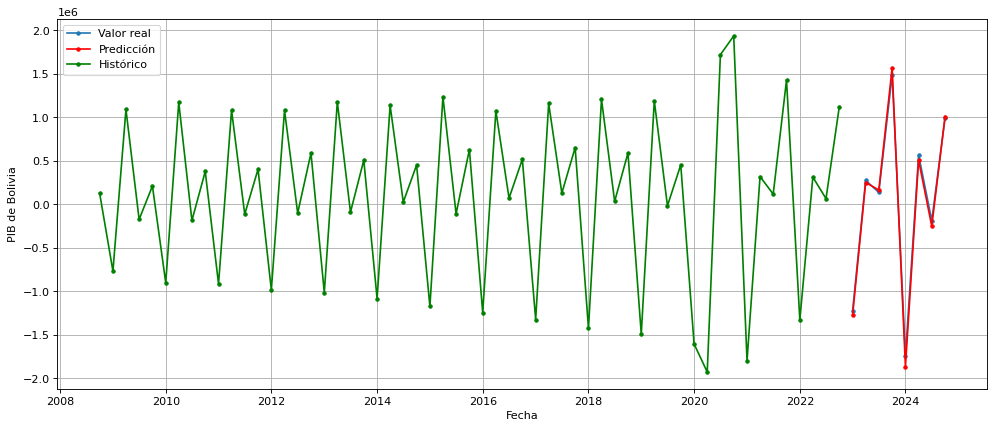

(<statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x2673557bee0>,
 fecha
 2023-01-01   -1.407702
 2023-04-01    0.164638
 2023-07-01    0.076445
 2023-10-01    1.524281
 2024-01-01   -2.020221
 2024-04-01    0.429267
 2024-07-01   -0.354633
 2024-10-01    0.948463
 Name: predicted_mean, dtype: float64,
 {'MAE': 0.05774463032397919,
  'MSE': 0.0044837693620751445,
  'RMSE': 0.06696095401108876,
  'MAPE': 16.587130651351227})

In [107]:
df4 = df.drop(['igae', 'exportaciones','importaciones', 'inversion_total'], axis=1)
generarModelo(df4)

In [ ]:
df5 = df.drop(['igae', 'exportaciones','consumo_final', 'inversion_total'], axis=1)
generarModelo(df5)